# Poincaré Sections

`DoublePendulumSubclassMomenta` is a class refactor aiming to plot Poincaré sections

In [52]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
#from contourpy.util.data import simple

from MathFunctions import *
from DoublePendulumSubclassMomentaCombination import DoublePendulum, DoublePendulumExplorer

----
&nbsp;
#### Variable & Parameter Declaration

In [53]:
l1, l2, m1, m2, M1, M2, g = sp.symbols('l1 l2 m1 m2 M1 M2 g', real=True, positive=True)

# Declare functions
theta1 = sp.Function('theta1')(t)
theta2 = sp.Function('theta2')(t)
p_theta_1 = sp.Function('p_theta_1')(t)
p_theta_2 = sp.Function('p_theta_2')(t)

In [54]:
# Set Unity Parameters for dimensionless pendulums
params = {
    g: 9.81,  # Acceleration due to gravity (m/s^2)
    l1: 1.0,  # Length of the first rod (m)
    l2: 1.0,  # Length of the second rod (m)
    m1: 1.0,  # Mass of the first bob (kg)
    m2: 1.0,  # Mass of the second bob (kg)
    M1: 1.0,  # Mass of first uniform rod (kg)
    M2: 1.0   # Mass of second uniform rod (kg)
}

In [55]:
# Time vector

stop = 60
fps = 400  # frames/second
no_steps = stop * fps

time = [0, stop, no_steps]

Increasing the time interval above 120 seconds does produce more Poincaré points but increases the noise

Going to try setting it for 60 seconds, hopefully less noise

----
&nbsp;
#### Potential Energy Calculator

We need to find $E_{\text{mech}}$ of the system which is all potential energy when releasing the pendulums from rest

In [56]:
def calculate_potential_energy(theta1_val, theta2_val, parameters, model='simple'):
    """
    Calculate the potential energy of the double pendulum system relative to the datum where theta1 = 0 and theta2 = 0.
    """
    if model == 'simple':
        V = -(m1 + m2) * g * l1 * sp.cos(theta1) - m2 * g * l2 * sp.cos(theta2)

    elif model == 'compound':
        V = -M1 * g * (l1 / 2) * sp.cos(theta1) - M2 * g * ((l1 * sp.cos(theta1)) + (l2 / 2) * sp.cos(theta2))

    else:
        raise ValueError("Model must be 'simple' or 'compound'")

    V = V.subs(parameters)
    V_subst = V.subs({theta1: theta1_val, theta2: theta2_val})
    # Calculate potential energy at theta1 = 0 and theta2 = 0 (datum)
    V_zero = V.subs({theta1: 0, theta2: 0})
    V_relative = V_subst - V_zero

    return V_relative

In [57]:
angle1 = 180
angle2 = 0

theta1val = np.deg2rad(angle1)
theta2val = np.deg2rad(angle2)

In [58]:
# Calculate potential energy for the 'simple' model
V_simple = calculate_potential_energy(theta1val, theta2val, params, model='simple')
print(f"Potential Energy (Simple Model): {V_simple:.2f} J")

# Calculate potential energy for the 'compound' model
V_compound = calculate_potential_energy(theta1val, theta2val, params, model='compound')
print(f"Potential Energy (Compound Model): {V_compound:.2f} J")

Potential Energy (Simple Model): 39.24 J
Potential Energy (Compound Model): 29.43 J


----
&nbsp;
#### `DoublePendulumExplorer` instantiation

In [59]:
# Testing simple pendulum instantiation
# Initial conditions (theta1, theta2, omega1, omega2)

time_single = [0, 20, 4000]
init_values = [0, 120, 0, 0]
pendulum1 = DoublePendulum(parameters=params, initial_conditions=init_values, time_vector=time_single)

In [60]:
pendulum1.precompute_positions()
#pendulum1.animate_pendulum(appearance='dark')

In [61]:
simple_explorer = DoublePendulumExplorer(params, time, 'simple')

DoublePendulumExplorer initialized with base class.
Mechanical energy: 39.24 J


In [62]:
compound_explorer = DoublePendulumExplorer(params, time, 'compound')

DoublePendulumExplorer initialized with base class.
Mechanical energy: 29.43 J


----
&nbsp;
### The Poincaré Section

Check [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) documentation to tweak integrator arguments

In [63]:
# Define additional parameters for the numerical integration
integrator_args = {
    'rtol': 1e-6,    # default is 1e-3
    'atol': 1e-8     # default is 1e-6
    #'method': 'RK45',
}

With looser tolerances defined above, the solver introduces small errors at each step that accumulate over time, leading to points that are slightly off from their true positions. 

- Tighter tolerances hopefully reduce this drift at the expense of computational load. 

- We want an accurate representation of the system’s dynamics and we want it in a 'reasonable runtime`. These parameters are mutually exclusive

`n_jobs` parameter in the Parallel module of `_run_simulations()`

- **`n_jobs=-1`**: 
  - Use all available CPU cores.
  - Maximizes speed, but can fully load the CPU.

- **`n_jobs=None` or `n_jobs=1`**: 
  - Use a single core (no parallelism).

- **`n_jobs=X`** (where `X` is a positive integer): 
  - Use `X` CPU cores.
  - Balance between speed and resource usage.

- **`n_jobs=-2`**: 
  - Use all but one core.
  - Keeps one core free for other tasks.

- **`n_jobs=-X`** (where `X` > 1): 
  - Use all but `X` cores.
  - Leaves more cores free for other processes.

## `simple model`

#### Setting $\theta_1$ to zero in Poincaré section

In [64]:
simple_explorer.find_poincare_section(analyze=True, **integrator_args)

Batch 1 of 9 complete. Time taken: 47.87 seconds.
Batch 2 of 9 complete. Time taken: 44.67 seconds.
Batch 3 of 9 complete. Time taken: 43.34 seconds.
Batch 4 of 9 complete. Time taken: 40.46 seconds.
Batch 5 of 9 complete. Time taken: 33.98 seconds.
Batch 6 of 9 complete. Time taken: 38.31 seconds.
Batch 7 of 9 complete. Time taken: 40.97 seconds.
Batch 8 of 9 complete. Time taken: 42.35 seconds.
Batch 9 of 9 complete. Time taken: 45.43 seconds.
Simulations Complete. Time taken: 467.43 seconds.


In [65]:
print(simple_explorer.initial_condition_data.shape)
print(type(simple_explorer.initial_condition_data))

i = 180
print(f"For i = {i}:\n"
      f"Length of initial condition data: {len(simple_explorer.initial_condition_data[180])}\n"
      f"Length of Poincaré data: {len(simple_explorer.poincare_section_data[180])}")

(720, 24000, 4)
<class 'numpy.ndarray'>
For i = 180:
Length of initial condition data: 24000
Length of Poincaré data: 48


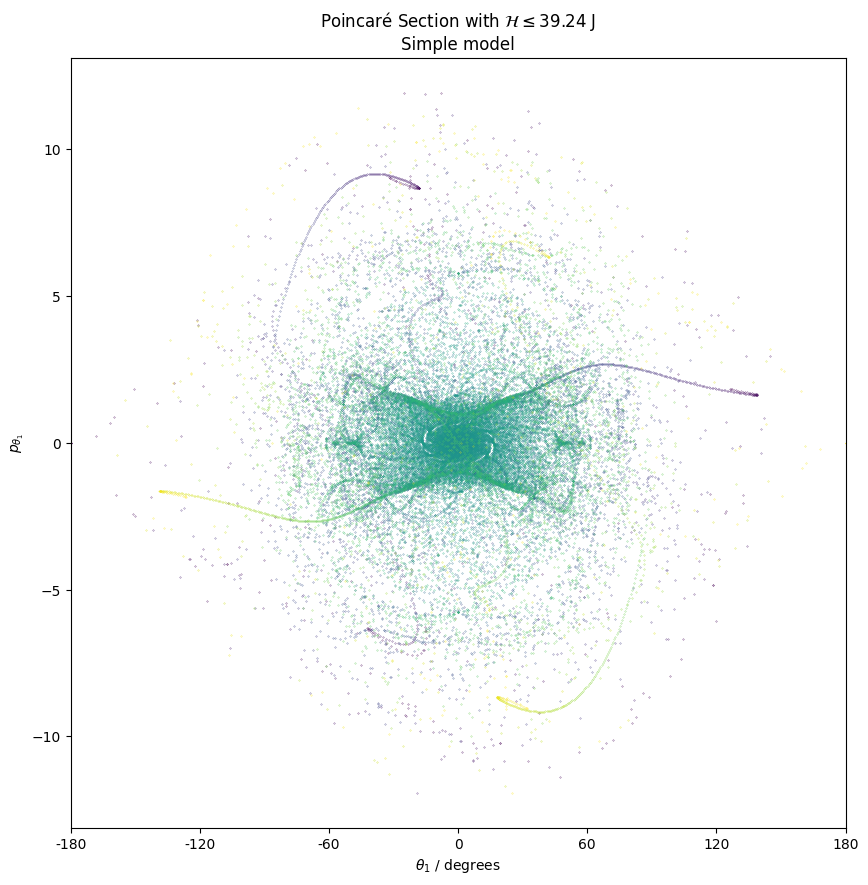

In [66]:
simple_explorer.plot_poincare_map()

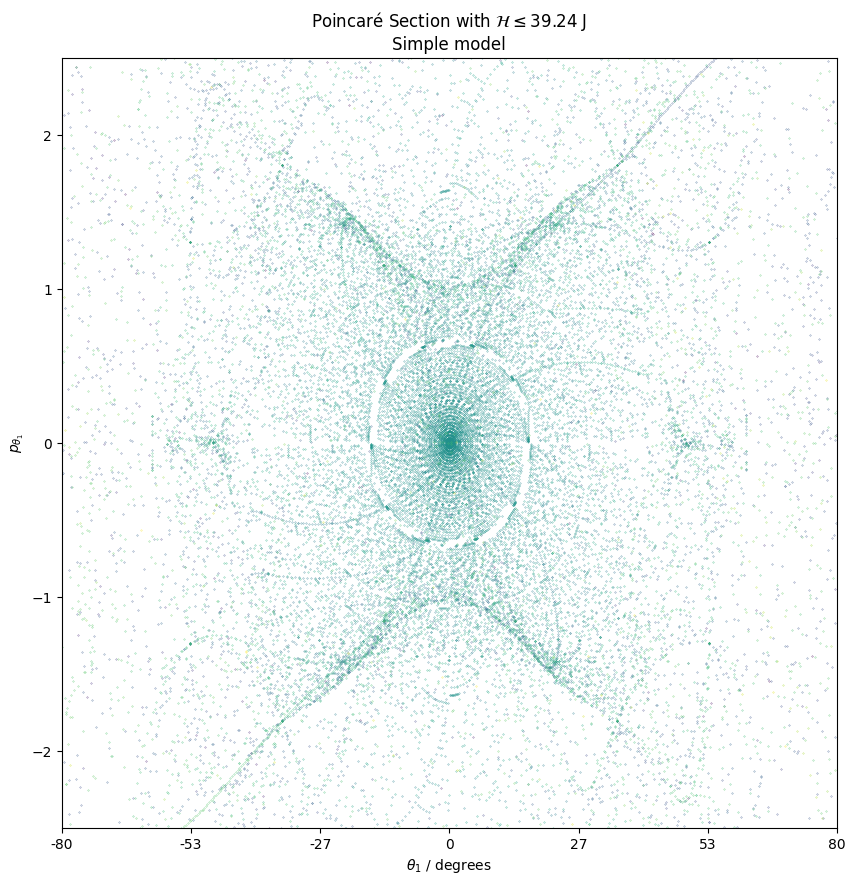

In [67]:
simple_explorer.plot_poincare_map(xrange=(-80*(np.pi/180), 80*(np.pi/180)), yrange=(-2.5, 2.5))

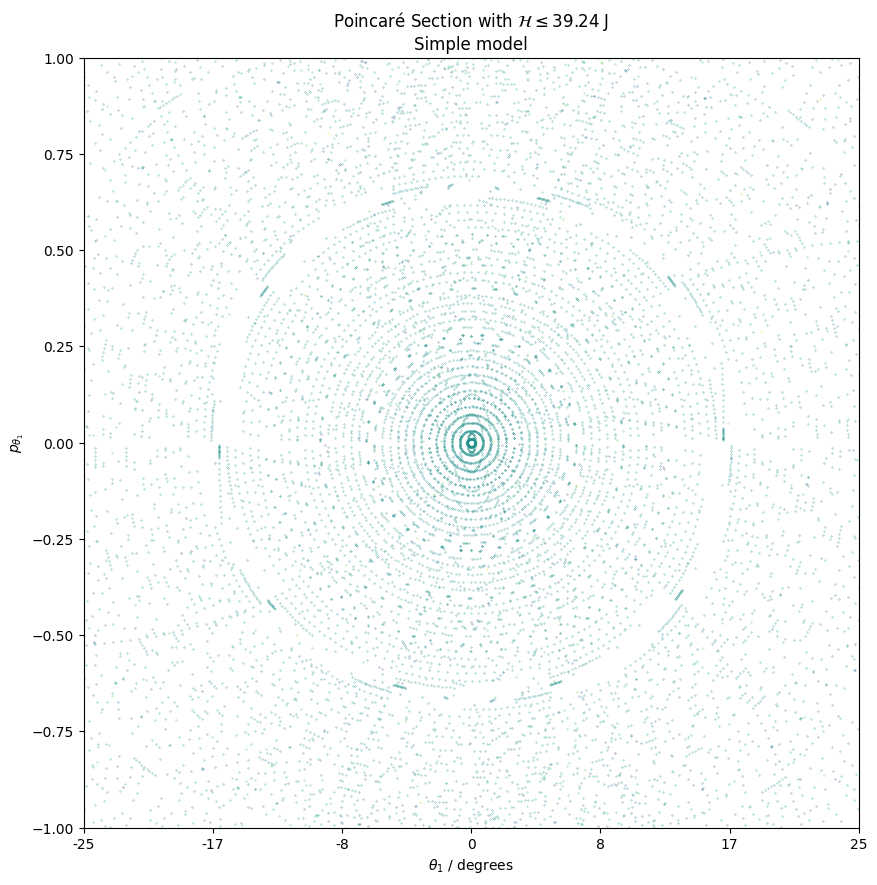

In [68]:
simple_explorer.plot_poincare_map(xrange=(-25*(np.pi/180), 25*(np.pi/180)), yrange=(-1, 1))

----
&nbsp;
#### Setting $\theta_2$ to zero in Poincaré section

In [69]:
simple_explorer.find_poincare_section(fixed_angle='theta2', **integrator_args)

Fixed angle changed from theta1 to theta2. Re-running simulations.
Batch 1 of 9 complete. Time taken: 20.13 seconds.
Batch 2 of 9 complete. Time taken: 20.61 seconds.
Batch 3 of 9 complete. Time taken: 19.67 seconds.
Batch 4 of 9 complete. Time taken: 19.82 seconds.
Batch 5 of 9 complete. Time taken: 19.41 seconds.
Batch 6 of 9 complete. Time taken: 19.53 seconds.
Batch 7 of 9 complete. Time taken: 20.30 seconds.
Batch 8 of 9 complete. Time taken: 20.11 seconds.
Batch 9 of 9 complete. Time taken: 19.87 seconds.
Simulations Complete. Time taken: 269.51 seconds.


In [70]:
simple_explorer.find_poincare_section(**integrator_args)

In [71]:
print(simple_explorer.initial_condition_data.shape)
print(type(simple_explorer.initial_condition_data))

i = 180
print(f"For i = {i}:\n"
      f"Length of initial condition data: {len(simple_explorer.initial_condition_data[180])}\n"
      f"Length of Poincaré data: {len(simple_explorer.poincare_section_data[180])}")

(720, 24000, 4)
<class 'numpy.ndarray'>
For i = 180:
Length of initial condition data: 24000
Length of Poincaré data: 80


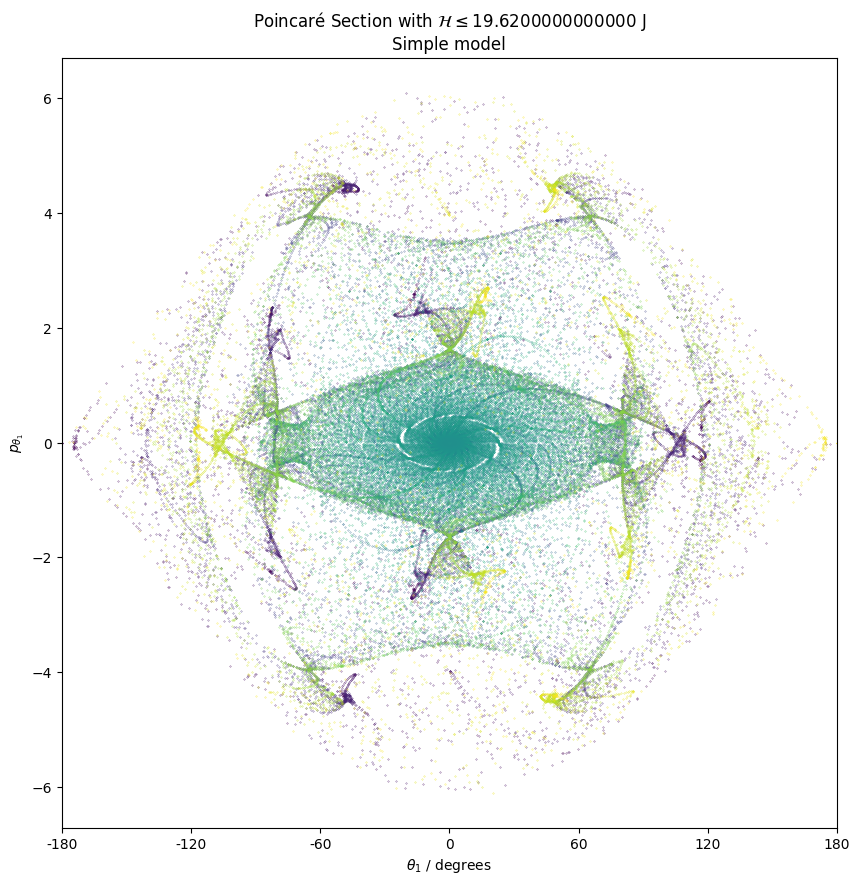

In [72]:
simple_explorer.plot_poincare_map()

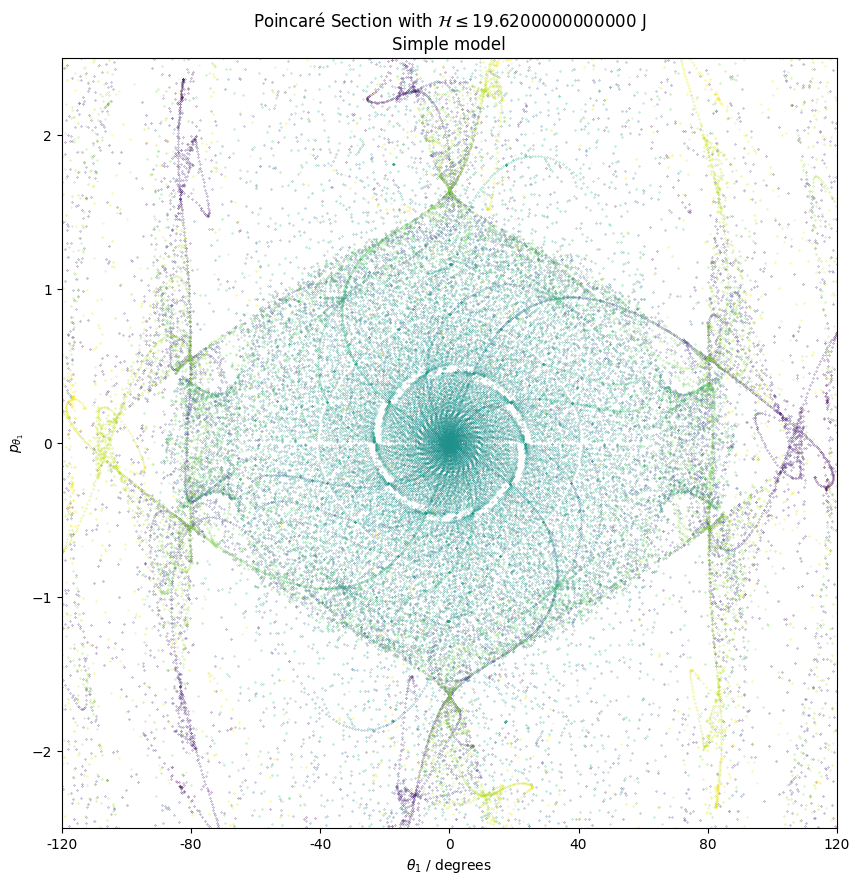

In [73]:
simple_explorer.plot_poincare_map(xrange=(-120*(np.pi/180), 120*(np.pi/180)), yrange=(-2.5, 2.5))

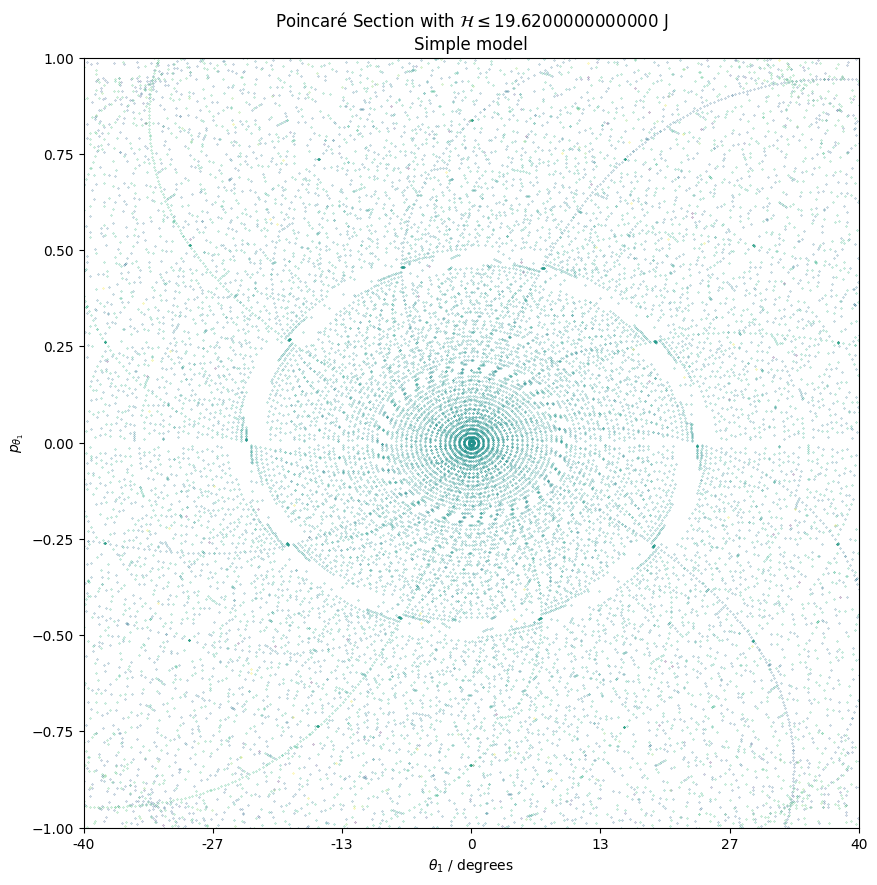

In [74]:
simple_explorer.plot_poincare_map(xrange=(-40*(np.pi/180), 40*(np.pi/180)), yrange=(-1, 1))

----
&nbsp;
## `compound model`

#### Setting $\theta_1$ to zero in Poincaré section

In [75]:
compound_explorer.find_poincare_section(analyze=True, **integrator_args)

Batch 1 of 9 complete. Time taken: 30.45 seconds.
Batch 2 of 9 complete. Time taken: 28.62 seconds.
Batch 3 of 9 complete. Time taken: 30.63 seconds.
Batch 4 of 9 complete. Time taken: 28.68 seconds.
Batch 5 of 9 complete. Time taken: 26.67 seconds.
Batch 6 of 9 complete. Time taken: 27.82 seconds.
Batch 7 of 9 complete. Time taken: 30.34 seconds.
Batch 8 of 9 complete. Time taken: 28.16 seconds.
Batch 9 of 9 complete. Time taken: 27.70 seconds.
Simulations Complete. Time taken: 349.12 seconds.


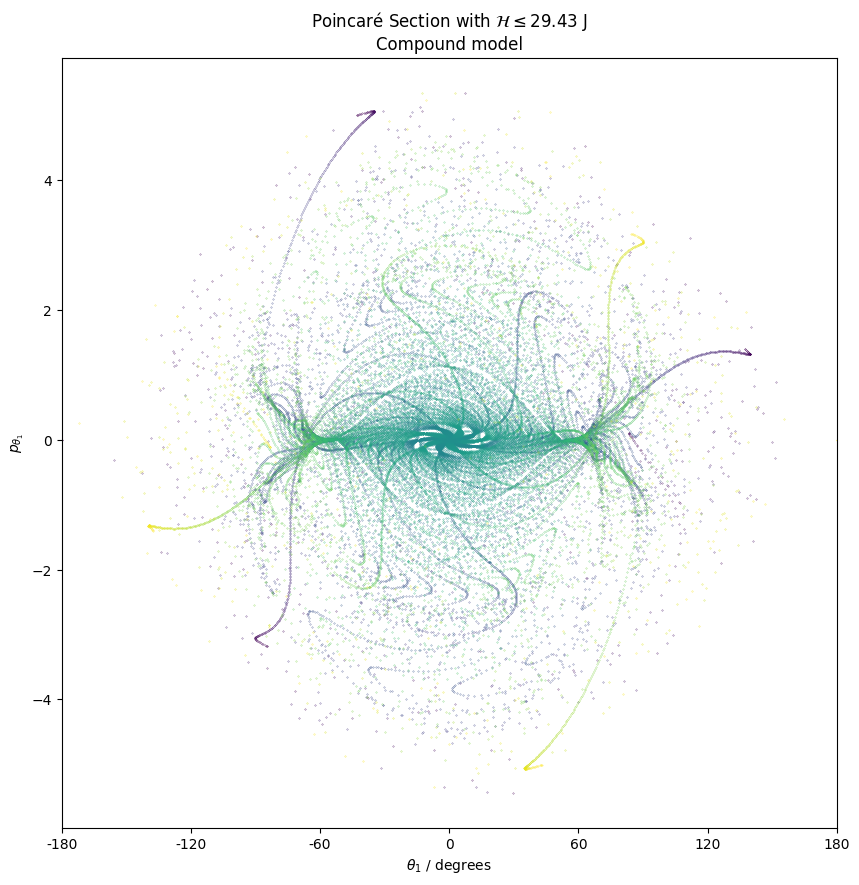

In [76]:
# special_angles_deg=[-90, -60, -30, 30, 60, 90]
compound_explorer.plot_poincare_map()

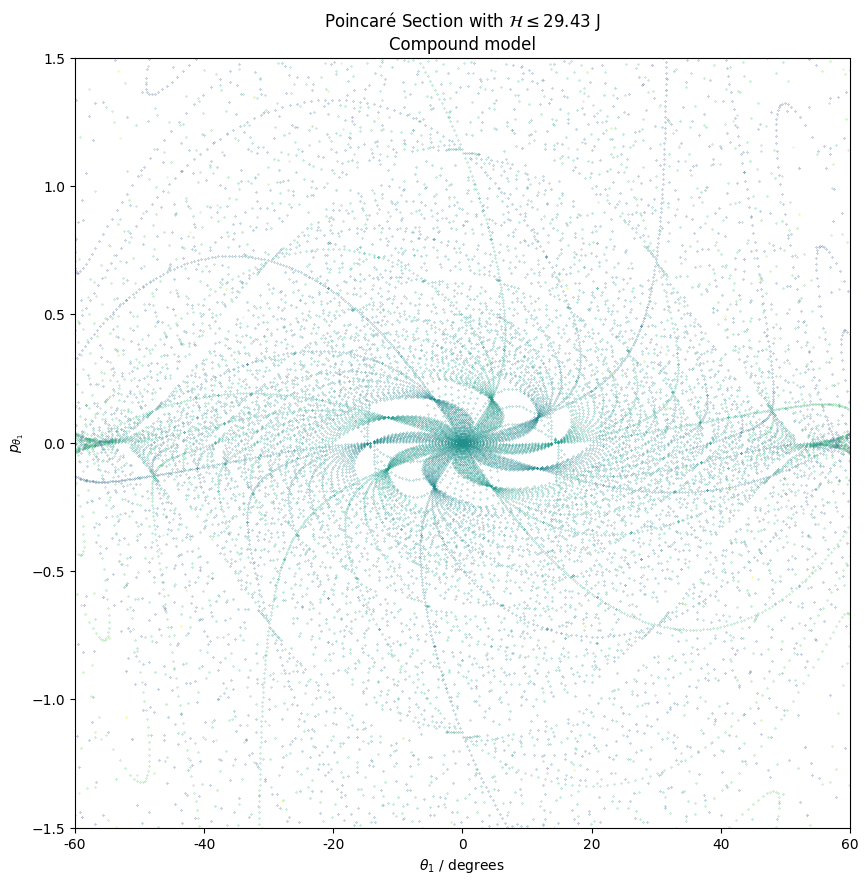

In [77]:
# special_angles_deg=[-90, -60, -30, 30, 60, 90]
compound_explorer.plot_poincare_map(xrange=(-60*(np.pi/180), 60*(np.pi/180)), yrange=(-1.5, 1.5))

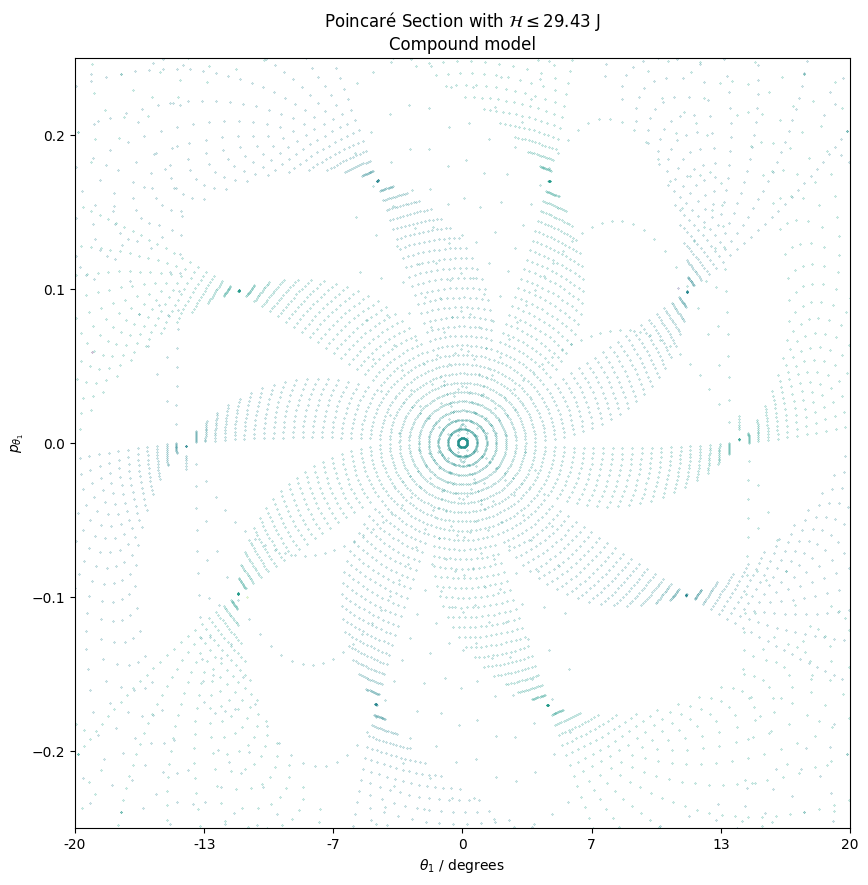

In [78]:
# special_angles_deg=[-90, -60, -30, 30, 60, 90]
compound_explorer.plot_poincare_map(xrange=(-20*(np.pi/180), 20*(np.pi/180)), yrange=(-0.25, 0.25))

----
&nbsp;
#### Setting $\theta_2$ to zero in Poincaré section

In [79]:
compound_explorer.find_poincare_section(fixed_angle='theta2', **integrator_args)

Fixed angle changed from theta1 to theta2. Re-running simulations.
Batch 1 of 9 complete. Time taken: 18.59 seconds.
Batch 2 of 9 complete. Time taken: 18.16 seconds.
Batch 3 of 9 complete. Time taken: 17.97 seconds.
Batch 4 of 9 complete. Time taken: 17.90 seconds.
Batch 5 of 9 complete. Time taken: 17.89 seconds.
Batch 6 of 9 complete. Time taken: 17.94 seconds.
Batch 7 of 9 complete. Time taken: 17.96 seconds.
Batch 8 of 9 complete. Time taken: 17.97 seconds.
Batch 9 of 9 complete. Time taken: 17.89 seconds.
Simulations Complete. Time taken: 252.34 seconds.


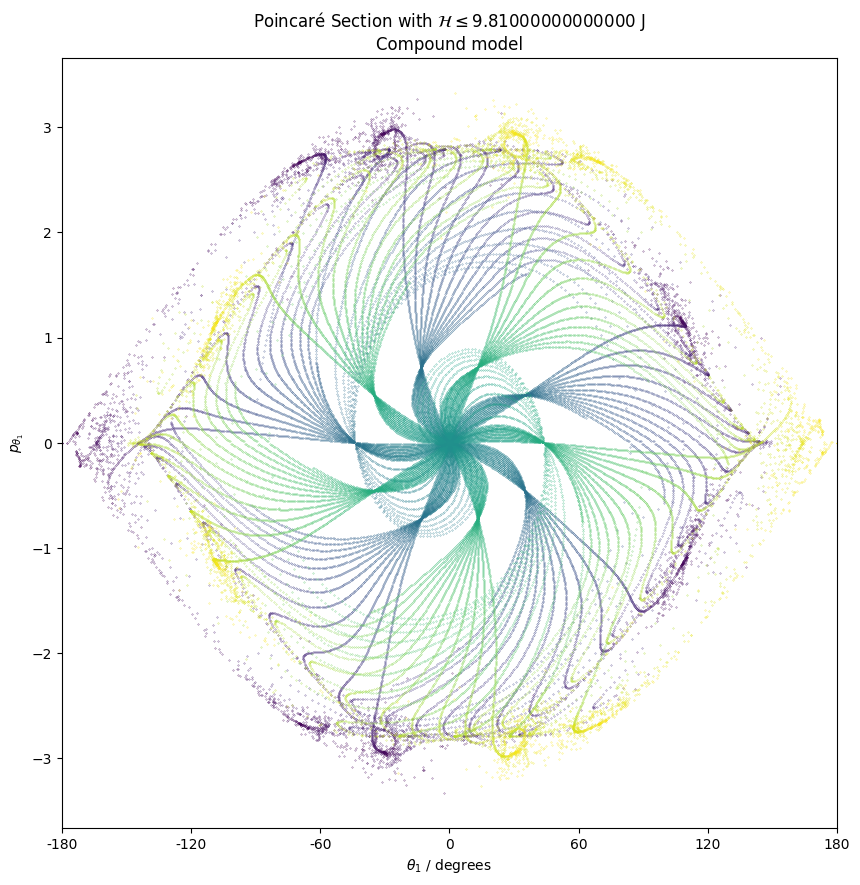

In [80]:
compound_explorer.plot_poincare_map()

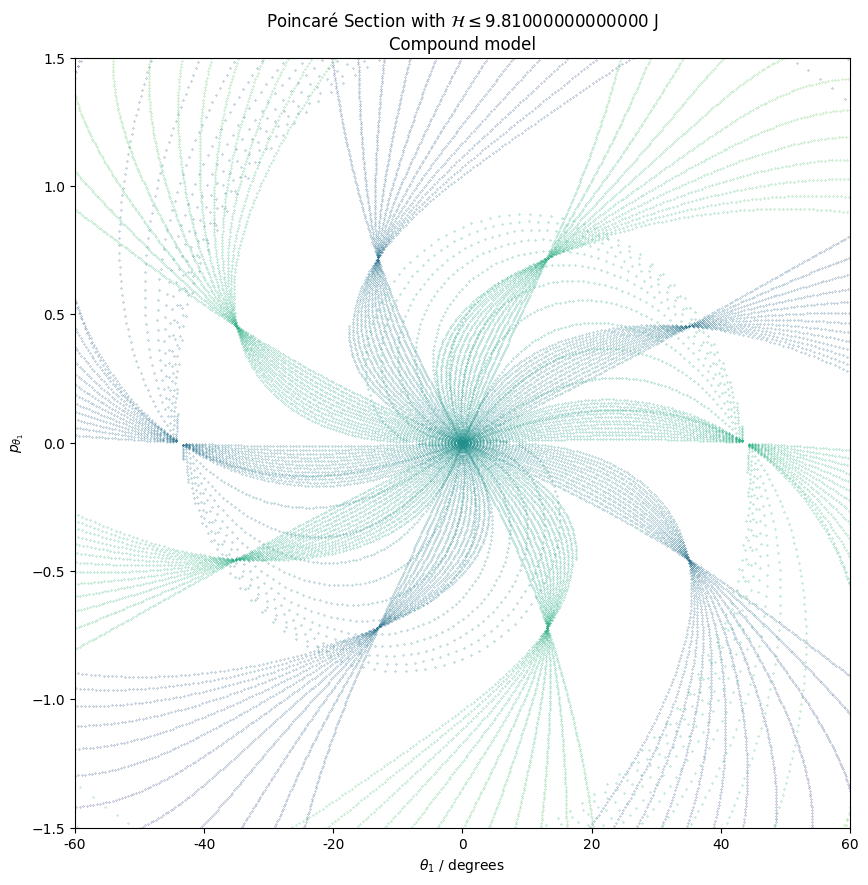

In [81]:
compound_explorer.plot_poincare_map(xrange=(-60*(np.pi/180), 60*(np.pi/180)), yrange=(-1.5, 1.5))